# Mixture Model

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pymc3 as pm
import scipy.stats as stats
import theano.tensor as T

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
np.random.seed(1234)

Let's suppose that there are two data sets, A and B, following two normal distributions, respectively

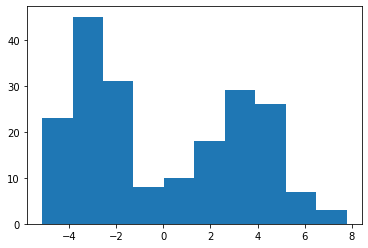

In [3]:
A = np.random.randn(100)*2+3 # mean:3, std:2
B = np.random.randn(100)*1-3 # mean:-3, std:1
All = np.hstack((A,B))
plt.hist(All)
plt.show()

If we fit a Normal distribution (estimating $\mu$ and $\sigma$) for the whole data...

In [10]:
model_all = pm.Model()
with model_all:
    mu_all = pm.Normal('mu_all', mu=0, sd=10)
    std_all = pm.Exponential('std_all', lam=1/10.)
    obs_all = pm.Normal('obs_all', mu=mu_all, sd=std_all, observed=All)
    trace = pm.sample(draws=3000)#, tune=50000, step=pm.Metropolis(), chains=1, cores=1)

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_21352/1806842708.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=3000)#, tune=50000, step=pm.Metropolis(), chains=1, cores=1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std_all, mu_all]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 33 seconds.


C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_21352/404859363.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace[::500])
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Seungjae Lee\.conda\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_21352/404859363.py:2: DeprecationWarning: The function `autocorrplot` from PyMC3 is just an alias for `plot_autocorr` from ArviZ. Please switch to `pymc3.plot_

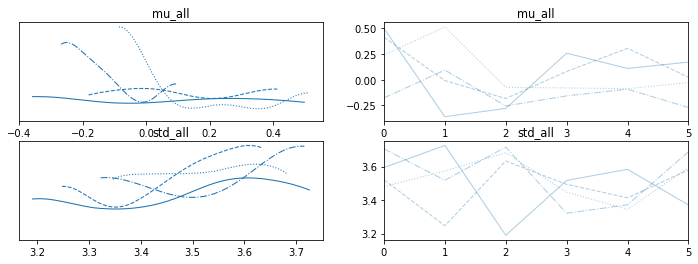

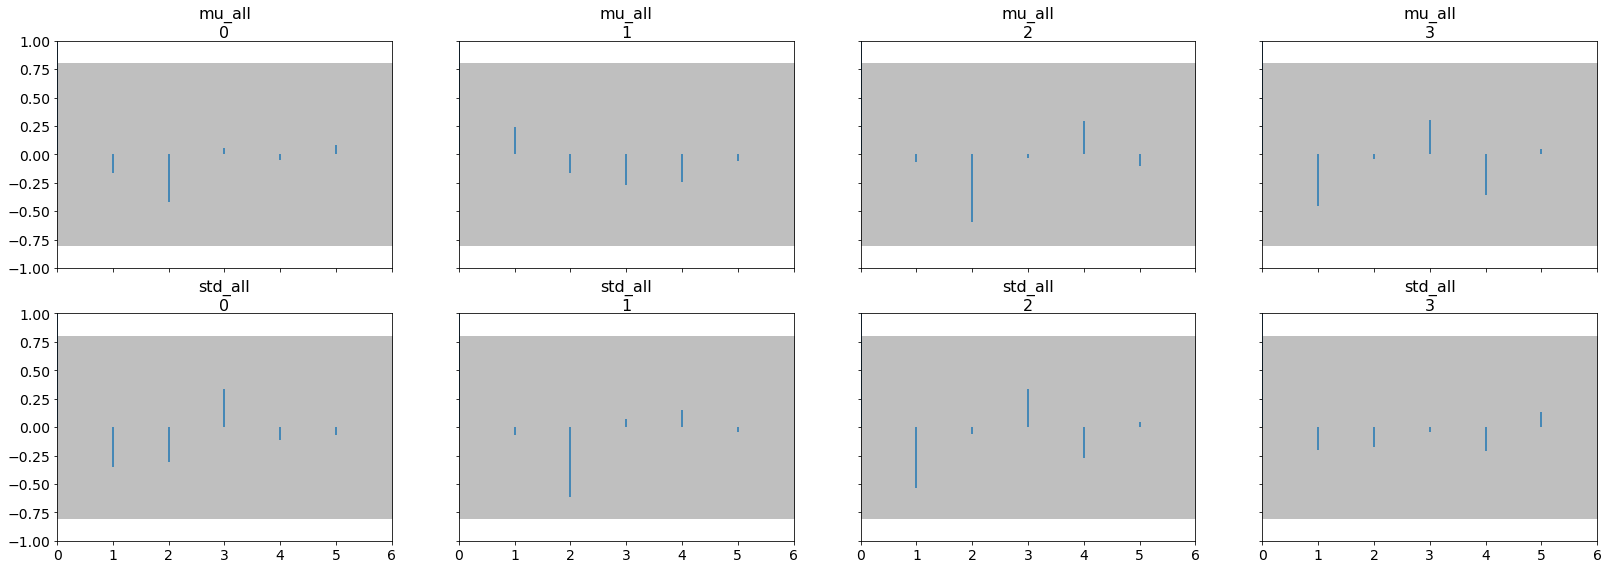

In [11]:
pm.traceplot(trace[::500])
pm.autocorrplot(trace[::500])
plt.show()

In [12]:
mu_all_sample = trace['mu_all'][::500]
std_all_sample = trace['std_all'][::500]

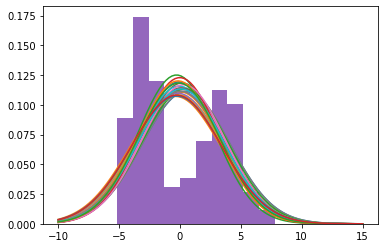

In [14]:
X_plot = np.linspace(-10,15,100)
for param in zip(mu_all_sample, std_all_sample):
    pdf = stats.norm.pdf(x=X_plot,loc=param[0],scale=param[1])
    plt.plot(X_plot, pdf)
plt.hist(All, density=True)
plt.show()

You can see that we get one flat Normal distribution which is quite different from either of them.<br>
How can we do better? Is there a way to get two normal distributions?<br>

We know that each data point is in either set A or B. Let's consider a discrete variable, $z$, corresponding to the two sets. However, this is a hidden variable since we assume we do not know which group (A or B) each data point is in like this.
So, we want to estimate $z$ for each data point as well as model parameters ($\mu$'s and $\sigma$'s). Let's sample $z_{1:D}$, $\mu$'s and $\sigma$'s.

In [15]:
def llk_norm(X, mu, tau):
    return (-tau * (X - mu)**2. + T.log(tau / np.pi / 2.)) / 2.

def llk_mixture(mu=None, std=None, z=None, X=None):
    mu1 = mu[0]
    std1 = std[0]
    tau1 = 1./std1**2.
    llk_norm1 = llk_norm(X=X, mu=mu1, tau=tau1)[:,None]
    
    mu2 = mu[1]
    std2 = std[1]
    tau2 = 1./std2**2.
    llk_norm2 = llk_norm(X=X, mu=mu2, tau=tau2)[:,None]
    
    llk_mixture = T.concatenate((llk_norm1, llk_norm2),axis=1)
        
    return T.sum(llk_mixture[T.arange(X.shape[0]),z])

In [16]:
model_mixture = pm.Model()
with model_mixture:
    mu = pm.Normal('mu', mu=0, sd=10, shape=2)
    std = pm.Exponential('std', lam=1/10., shape=2)
    pi = pm.Dirichlet('pi', np.ones(2))
    z = pm.Categorical('z',p=pi,shape=All.shape[0])
    obs = pm.Potential('obs',llk_mixture(mu=mu, std=std, z=z, X=All))
    
    step_cont = pm.Metropolis(vars=[model_mixture.model['mu'],
                                    model_mixture.model['std'],
                                    model_mixture.model['pi']])
    step_disc = pm.CategoricalGibbsMetropolis([model_mixture.model['z']])
    trace = pm.sample(draws=3000)#, tune=10000, step=[step_cont,step_disc], chains=1, cores=1)

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_21352/922692903.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=3000)#, tune=10000, step=[step_cont,step_disc], chains=1, cores=1)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [pi, std, mu]
>BinaryGibbsMetropolis: [z]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 133 seconds.
C:\Users\Seungjae Lee\.conda\envs\pymc_env\lib\site-packages\arviz\stats\diagnostics.py:560: RuntimeWarning: invalid value encountered in sqrt
  rhat_value = np.sqrt(
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


## Stop it by clicking on the interrupt button!<br>
It is too slow...since we are sampling 200 z's...<br>
There is a way to normalize z's out from the problem so that we do not need to sample z's explicitly.

In [20]:
from pymc3.math import logsumexp
def llk_mixture_normalize(mu=None, std=None, pi=pi, X=None):
    mu1 = mu[0]
    std1 = std[0]
    tau1 = 1./std1**2.
    llk_norm1 = llk_norm(X=X, mu=mu1, tau=tau1)[:,None]
    
    mu2 = mu[1]
    std2 = std[1]
    tau2 = 1./std2**2.
    llk_norm2 = llk_norm(X=X, mu=mu2, tau=tau2)[:,None]
    
    llk_mixture = T.concatenate((llk_norm1, llk_norm2),axis=1)
    
    return T.sum(logsumexp(llk_mixture + T.log(pi), axis=1))

In [ ]:
model_mixture = pm.Model()
with model_mixture:
    mu = pm.Normal('mu', mu=0, sd=10, shape=2)
    std = pm.Exponential('std', lam=1/10., shape=2)
    pi = pm.Dirichlet('pi', np.ones(2))
#     z = pm.Categorical('z',p=pi,shape=All.shape[0])
    obs = pm.Potential('obs',llk_mixture_normalize(mu=mu, std=std, pi=pi, X=All))
    
#     step_cont = pm.Metropolis(vars=[model_mixture.model['mu'],
#                                     model_mixture.model['std'],
#                                     model_mixture.model['pi']])
#     step_disc = pm.CategoricalGibbsMetropolis([model_mixture.model['z']])
    trace = pm.sample(draws=3000)#, tune=10000, step=pm.Metropolis(), chains=1, cores=1)

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_21352/4008263081.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=3000)#, tune=10000, step=pm.Metropolis(), chains=1, cores=1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi, std, mu]


In [ ]:
pm.traceplot(trace[::500])
pm.autocorrplot(trace[::500])
plt.show()

In [ ]:
mu_sample = trace['mu'][::500,:]
std_sample = trace['std'][::500,:]

In [ ]:
X_plot = np.linspace(-10,15,100)
for param in zip(mu_sample, std_sample):
    pdf1 = stats.norm.pdf(x=X_plot,loc=param[0][0],scale=param[1][0])
    pdf2 = stats.norm.pdf(x=X_plot,loc=param[0][1],scale=param[1][1])
    plt.plot(X_plot, pdf1)
    plt.plot(X_plot, pdf2)
plt.hist(A,label='A',density=True)
plt.hist(B,label='B',density=True)
plt.legend()
plt.show()

The model discovered two normal distributions! In other words, two sub-models for two groups (clusters) of data.<br>
We the result, we can classify data points.

## Homework
So, can we do similar work with our previous data? I know it will be challenging.

In [ ]:
# import / plot data
Data3 = pd.read_excel(os.path.join(os.path.dirname('__file__'), '..', 'data', 'Data.xlsx'))

plt.scatter(Data3['Area [sq ft]'], Data3['Elec [kBTU]'], facecolors='None', edgecolors='green', label='Data3')

plt.xlabel('Floor Area [$\mathrm{ft}^2$]')
plt.ylabel('Elec. Consumption [$\mathrm{kBTU}$]')
plt.ylim(0.5e+8, 2.5e+8)
plt.legend()
plt.show()